In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal

%matplotlib inline

In [2]:
class GaussianProcess(nn.Module):
    def __init__(self, mean, lengthscale, noise=0.05):
        super(GaussianProcess, self).__init__()
        self.ls=lengthscale
        self.mean=mean
        self.var=noise**2

    def covar_matrix(self,x):
        K=torch.cdist(x.div(self.ls),x.div(self.ls),p=2).pow_(2).div_(-2).exp_()
        return K+self.var*torch.eye(x.shape[0])##
    
    def log_prob(self,inputs,f):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0]),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.log_prob(f)
    def forward(self, inputs, n=1):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0]),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.sample((n,)).squeeze()
    

In [134]:
GP=GaussianProcess(mean=torch.tensor(0.),lengthscale=1., noise=0.01)

In [135]:
import seaborn as sns
x=torch.Tensor([[0.],[1.]])
print(x.shape) 
n=1000
y=GP(x,n)

GP.covar_matrix(x)

torch.Size([2, 1])


tensor([[1.0001, 0.6065],
        [0.6065, 1.0001]])

tensor(0.7010)

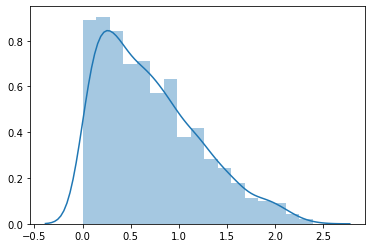

In [136]:
distances=torch.abs(y[:,0]-y[:,1])
sns.distplot(distances)

distances.mean()

torch.Size([1000, 2])


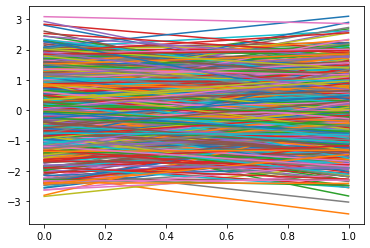

In [137]:

print(y.shape)
for i in range(n):
    plt.plot(x,y[i])

torch.Size([500, 500])

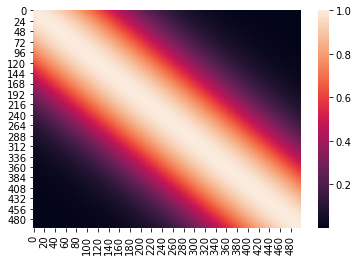

In [419]:
inputs=torch.linspace(-2,2,500).unsqueeze(-1)#(2*torch.rand((100,1))-1).sort(0)[0])
import seaborn as sns

sns.heatmap(GP.covar_matrix(inputs))
GP.covar_matrix(inputs).shape




In [420]:
f=GP(inputs,100)
GP.log_prob(inputs,f)

tensor([1534.0477, 1530.6770, 1561.9712, 1542.5061, 1541.7643, 1547.7843,
        1559.9979, 1561.9800, 1510.0645, 1562.6899, 1507.0938, 1530.8796,
        1537.9333, 1585.0939, 1555.8485, 1573.3944, 1546.7704, 1532.3242,
        1526.9480, 1549.6910, 1534.1398, 1545.2821, 1505.7845, 1547.3945,
        1551.2405, 1573.0341, 1517.1034, 1545.1399, 1516.4167, 1549.7593,
        1544.1216, 1531.1714, 1554.0293, 1556.5923, 1549.0652, 1516.4919,
        1562.9639, 1521.4082, 1541.9402, 1564.5100, 1496.3127, 1539.9124,
        1551.0117, 1572.0498, 1538.3517, 1562.9147, 1538.6132, 1561.9490,
        1553.7776, 1578.4214, 1540.8973, 1547.8784, 1541.1078, 1566.0593,
        1552.0511, 1544.5687, 1531.8167, 1560.7970, 1536.5046, 1558.2830,
        1549.8064, 1528.5311, 1550.3173, 1558.7620, 1540.4005, 1534.0208,
        1514.7500, 1542.4755, 1573.1425, 1529.5098, 1544.8149, 1543.3652,
        1567.3965, 1534.8070, 1575.5966, 1512.3534, 1564.4501, 1535.9556,
        1558.6868, 1551.2878, 1552.757

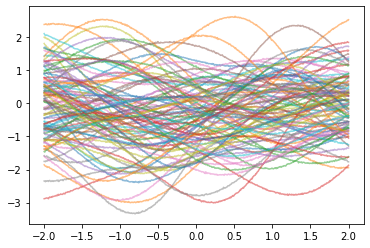

In [421]:
for i in range(100):
    plt.plot(inputs,GP(inputs),alpha=0.5)

In [138]:
GP=GaussianProcess(mean=torch.tensor(0.),lengthscale=1.,noise=0.01)

torch.Size([10, 10])

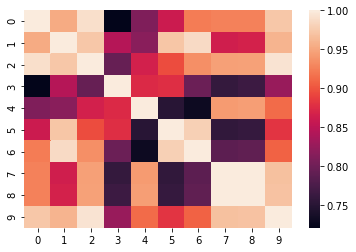

In [139]:
N=2
inputs=torch.rand(10,N)
import seaborn as sns

sns.heatmap(GP.covar_matrix(inputs))
GP.covar_matrix(inputs).shape




In [140]:
f=GP(inputs,10)
GP.log_prob(inputs,f)

tensor([ 9.7147, 11.8356, 11.2191,  9.6577,  4.2608, 12.6271,  6.8511, 10.4060,
         9.7806,  7.4147])

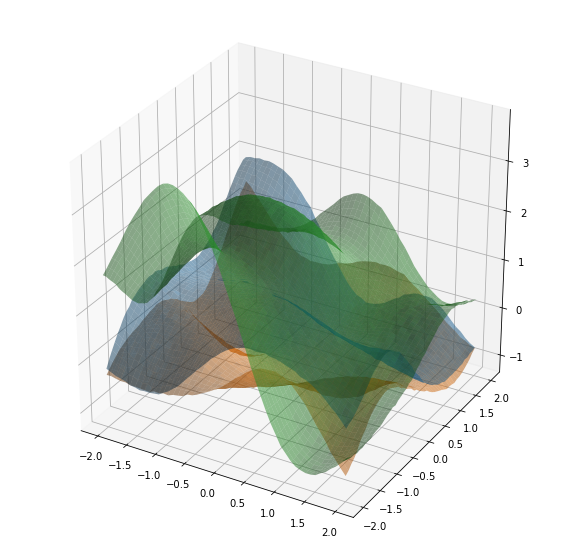

In [141]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
n=50
X=torch.linspace(-2,2,n)
XX,YY = torch.meshgrid(X,X)#torch.cartesian_prod(X, X)
XX_=torch.stack([XX,YY],dim=2).view(n**2,-1)
for i in range(3):
    ax.plot_surface(XX.numpy(),YY.numpy(),GP(XX_).view(n,n).numpy(),alpha=0.5)

In [143]:
cd ..

/home/yann/IVISpaces


In [192]:
import numpy as np
import math
import torch
from torch import nn


from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp, BigGenerator, MeanFieldVariationalDistribution, GaussianProcess
from Tools import AverageNormalLogLikelihood, logmvn01pdf
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI_noise import IVI

from tqdm import trange

import timeit
import os

def makedirs(filename):
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))



## Hyperparameters ##

#predictive model
layerwidth=50
nblayers=1
activation=nn.ReLU()

#generative model
lat_dim=5

#optimizer
learning_rate=0.005

#scheduler
patience=30
lr_decay=.7#.7
min_lr= 0.0001
n_epochs=1#2000#5000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour

batch_size=50

sigma_prior=.5# TO DO check with other experiments setup.sigma_prior    



def MFVI_noise(dataset,device, seed):
    
    setup_ = get_setup(dataset)
    setup=setup_.Setup(device, seed=seed) 

    x_train, y_train=setup.train_data()
    

    std_y_train = torch.tensor(1.)
    if hasattr(setup, '_scaler_y'):
        std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    size_data=len(train_dataset)
    #batch_size=int(np.min([size_data // 6, 500])) #50 works fine too!
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    ## predictive model
    input_dim=x_train.shape[1]
    param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation) 
    
    MFVI=MeanFieldVariationalDistribution(param_count, std_init=0. ,sigma=0.001, device=device)    

    _sigma_noise=torch.log(torch.tensor(1.).exp()-1.).clone().to(device).detach().requires_grad_(True)
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

    def ELBO(x_data, y_data, MFVI, _sigma_noise):
        alpha=(len(x_data)/size_data) #TODO check with alpah=1.

        y_pred=model(x_data,MFVI(n_samples_LL))
        sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.)

        Average_LogLikelihood=AverageNormalLogLikelihood(y_pred, y_data, sigma_noise)
        theta=MFVI(n_samples_KL)
        the_KL=MFVI.log_prob(theta).mean()-logmvn01pdf(theta,sigma_prior).mean()
        the_ELBO= - Average_LogLikelihood+ alpha* the_KL
        return the_ELBO, the_KL, Average_LogLikelihood, sigma_noise
    
    optimizer = torch.optim.Adam(list(MFVI.parameters())+[_sigma_noise], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2*patience, factor=lr_decay, min_lr=min_lr)
    Run=IVI(train_loader, ELBO, optimizer)

    start = timeit.default_timer()
    with trange(n_epochs) as tr:
        tr.set_description(desc=dataset+'/MFVI', refresh=False)
        for t in tr:
            scores=Run.run(MFVI,_sigma_noise)

            scheduler.step(scores['ELBO'])
            tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'], sigma=scores['sigma'])

            if scores['lr'] <= 1e-4:
                break
    stop = timeit.default_timer()
    time = stop - start
    
    

    theta=MFVI(1000).detach()
    sigma_noise = torch.log(torch.exp(_sigma_noise) + 1.).detach().cpu()
    x_test, y_test=setup.test_data()
    y_pred=model(x_test,theta)
    metrics=get_metrics(y_pred, sigma_noise, y_test, std_y_train, 'MFVI', time)
    return metrics

def get_metrics(y_pred, sigma_noise, y_test, std_y_train, method, time):
    metrics=evaluate_metrics(y_pred, sigma_noise.view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
    metrics.update({'time [s]': time})
    metrics.update({'std noise': sigma_noise.item()})
    metrics_list=list(metrics.keys())
#    for j in metrics_list:
#        metrics[(method,j)] = metrics.pop(j)
    return metrics

In [193]:
results=[MFVI_noise('yacht','cuda', seed) for seed in range(2)]

yacht/MFVI: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s, ELBO=282, KL=1.24e+3, LogLike=-67.4, lr=0.005, sigma=0.994]


In [199]:
import pandas as pd
mean=pd.DataFrame(results).mean()
std=pd.DataFrame(results).std()
mean,std

(RMSE         13.890449
 LPP          -4.058891
 gLPP         -4.058891
 WAIC         -4.058892
 PICP          0.935484
 MPIW         59.170765
 time [s]      0.045183
 std noise     0.992034
 dtype: float64,
 RMSE         1.165360
 LPP          0.069944
 gLPP         0.069944
 WAIC         0.069944
 PICP         0.000000
 MPIW         0.401891
 time [s]     0.001764
 std noise    0.002228
 dtype: float64)

In [198]:
df=pd.DataFrame(results)
pd.concat([df[c].str.split('±', expand=True).rename(columns={0:c, 1:c+' std'})
                      for c in df.columns], axis=0)

AttributeError: Can only use .str accessor with string values!

In [196]:
for c in df.columns:
    print(c)

RMSE
LPP
gLPP
WAIC
PICP
MPIW
time [s]
std noise
